In [1]:
import torchtext as TT
import torch
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import spacy
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torchtext import data, datasets
from torchtext.vocab import vocab
from collections import OrderedDict

#from torchtext import vocab

with open('data/traindata.en','r') as f:
    traindata = f.readlines()
with open('data/traindata.es', 'r') as f:
    trainlabels = f.readlines()
with open('data/validdata.en','r') as f:
    validdata = f.readlines()
with open('data/validdata.es', 'r') as f:
    validlabels = f.readlines()
with open('data/testdata.en','r') as f:
    testdata = f.readlines()
with open('data/testdata.es', 'r') as f:
    testlabels = f.readlines()

spacy_es = spacy.load("es_core_news_sm")
spacy_eng = spacy.load("en_core_web_sm")


import string

def tokenize_es(text):
    return [
        tok.text.lower().strip(string.punctuation + string.whitespace)
        for tok in spacy_es(text)
        if tok.text.strip(string.punctuation + string.whitespace)
    ]

def tokenize_eng(text):
    return [
        tok.text.lower().strip(string.punctuation + string.whitespace)
        for tok in spacy_eng(text)
        if tok.text.strip(string.punctuation + string.whitespace)
    ]
'''

def tokenize_es(text):
    return [tok.text for tok in spacy_es.tokenizer(text)]

def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]
'''

train_iter = zip(traindata,trainlabels)
counter_en = Counter()
counter_es = Counter()

for (line,label) in train_iter:
    #print(label)
    counter_en.update(tokenize_eng(line))
    counter_es.update(tokenize_es(label))

valid_iter = zip(validdata, validlabels)
for (line, label) in valid_iter:
    counter_en.update(tokenize_eng(line))
    counter_es.update(tokenize_es(label))

test_iter = zip(testdata, testlabels)
for (line, label) in test_iter:
    counter_en.update(tokenize_eng(line))
    counter_es.update(tokenize_es(label))

#print(counter_en)  contatore frecuencia palabras
#print(counter_es)
ordered_dict_en = OrderedDict(sorted(counter_en.items(), key=lambda x: x[1], reverse=True))
ordered_dict_es = OrderedDict(sorted(counter_es.items(), key=lambda x: x[1], reverse=True))

special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']  # You can customize this list

vocab_en = vocab(ordered_dict_en, specials=special_tokens)
vocab_es = vocab(ordered_dict_es, specials=special_tokens)

#print(vocab_en.get_itos())

default_index = -1
unk_token = '<unk>'
vocab_en.set_default_index(default_index)
vocab_es.set_default_index(default_index)

vocab_en.set_default_index(vocab_en[unk_token])
vocab_es.set_default_index(vocab_es[unk_token])


    
#vocab_en = TT.vocab.Vocab(counter_en)
#vocab_es = TT.vocab.Vocab(counter_es)

## Create reverse vocabularies
#reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
#reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}

#print(tokenize_es(trainlabels[0]))

text_pipeline = lambda x: [vocab_en.lookup_indices([token]) for token in tokenize_eng(x)]
label_pipeline = lambda x: [vocab_es.lookup_indices([token]) for token in tokenize_es(x)]



#print(myVocabulary.lookup_indices(['a'])) # [1, 0]
#print(myVocabulary.lookup_tokens([0]))  # ['b', 'a']

class TextData(torch.utils.data.Dataset):
    def __init__(self, text, labels):
        super(TextData, self).__init__()
        self.labels = labels
        self.text = text
        
    def __getitem__(self, index):
        return self.labels[index], self.text[index]
    
    def __len__(self):
        return len(self.labels)


def tokenize_batch(batch, max_len=300):
    '''
    tokenizer to use in DataLoader
    takes a text batch of text dataset and produces a tensor batch, converting text and labels though tokenizer, labeler
    tokenizer is a global function text_pipeline
    labeler is a global function label_pipeline
    max_len is a fixed len size, if text is less than max_len it is padded with ones (pad number)
    if text is larger that max_len it is truncated but from the end of the string
    '''
    labels_list, text_list = [], []
    for _label,_text in batch:
        #print(_text)
        #print(_label)
        labels_holder = torch.ones(max_len, dtype=torch.int64) # fixed size tensor of max_len
        processed_labels = torch.tensor(label_pipeline(_label), dtype=torch.int32).squeeze()
        #print(labels_holder.shape)
        #print(processed_labels.shape)
        pos = min(300, len(processed_labels))
        if len(processed_labels) == 0:
            print('error')
        labels_holder[-pos:] = processed_labels[-pos:]
        labels_list.append(labels_holder.unsqueeze(dim=0))
        
        text_holder = torch.ones(max_len, dtype=torch.int64) # fixed size tensor of max_len
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32).squeeze()
        pos = min(300, len(processed_text))
        text_holder[-pos:] = processed_text[-pos:]
        text_list.append(text_holder.unsqueeze(dim=0))
    return torch.cat(text_list, dim=0),torch.cat(labels_list, dim=0)

train_dataset = TextData(traindata,trainlabels)
valid_dataset = TextData(validdata,validlabels)
test_dataset = TextData(testdata,testlabels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=tokenize_batch)

# Create reverse vocabularies
reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}

def untokenize_batch(tokenized_batch,reverse_vocab, max_len=300, pad_token=0, unk_token=1):
    untokenized_batch = []
    for tokenized_sequence in tokenized_batch:
        sequence_without_padding = tokenized_sequence[tokenized_sequence != pad_token]
        sequence_without_unknown = sequence_without_padding[sequence_without_padding != unk_token]
        words = [reverse_vocab[token.item()] for token in sequence_without_unknown]

        untokenized_batch.append(words)
    return untokenized_batch

print("Length english vocabulary:", len(vocab_en))
print("Length spanish vocabulary:",len(vocab_es))
print('')
for batch in train_loader:
    txt,lbl = batch

    print("Text:", txt.shape)
    sentence = untokenize_batch(txt,reverse_vocab_en)
    print(''.join([' '.join(s) + '\n' for s in sentence]))
    
    print("Labels:", lbl.shape)
    sentence = untokenize_batch(lbl,reverse_vocab_es)
    print(''.join([' '.join(s) + '\n' for s in sentence]))
    break  # Stop after the first batch

2024-02-04 16:05:13.497328: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-04 16:05:13.640272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:05:13.640354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:05:13.640456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 16:05:13.667003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

Length english vocabulary: 279
Length spanish vocabulary: 288

Text: torch.Size([8, 300])
the sun is shining brightly today
i love playing with my colorful toys
let s go on a fun adventure together
flowers bloom in the spring season
my puppy likes to chase its tail
rainbows appear after the rain
the moon and stars light up the night
birds sing sweet songs in the morning

Labels: torch.Size([8, 300])
el sol brilla intensamente hoy
me encanta jugar con mis juguetes coloridos
vamos a tener una divertida aventura juntos
las flores florecen en la temporada de primavera
a mi cachorro le gusta perseguir su cola
los arcoíris aparecen después de la lluvia
la luna y las estrellas iluminan la noche
los pájaros cantan dulces canciones por la mañana



In [2]:
#######################################models
from torch import nn
import torch
import random


class Encoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, layers_size, dropout_prob) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.input_size = input_size
        self.dropout = nn.Dropout(dropout_prob)
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, layers_size, bidirectional=True)
        
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        
    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size
        
        x = self.embedding(x)
        x = self.dropout(x)
        # x shape: (seq_length, N, embedding_size)
        
        encoder_states, (hidden, cell) = self.lstm(x)
        # x shape: (seq_length, N, hidden_size)
        
        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))
        
        return encoder_states, hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, layers_size, dropout_prob) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.input_size = input_size
        self.dropout = nn.Dropout(dropout_prob)
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(hidden_size * 2 + embedding_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        
    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)

        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)

        # attention: (seq_length, N, 1), snk
        # encoder_states: (seq_length, N, hidden_size*2), snl
        # we want context_vector: (1, N, hidden_size*2), i.e knl
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        lstm_input = torch.cat((context_vector, embedding), dim=2)
        # lstm_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell
    
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, len_spanish_vocab, teacher_forcing_ratio=0.7):
        self.batch_size = source.shape[1]
        self.target_len = target.shape[0]
        self.target_vocab_size =  len_spanish_vocab
        outputs = torch.zeros(self.target_len, self.batch_size, self.target_vocab_size)
        
        encoder_states, hidden, cell = self.encoder(source)
        x = target[0]
        
        for i in range(1, self.target_len):
            perdiction, hidden, cell = self.decoder(x, encoder_states, hidden, cell)
            outputs[i] = perdiction
            best_guess = perdiction.argmax(1)
            x = target[i] if random.random() < teacher_forcing_ratio else best_guess
        
        return outputs
    
    def predict(self, x):
        x = self.encoder.embedding(x)
        x = self.encoder.lstm(x)
        x = self.decoder.lstm(x)
        return x
    
    def save_checkpoint(self, state, filename="my_checkpoint.pth.tar"):
        print("=> Saving checkpoint")
        torch.save(state, filename)

    def load_checkpoint(self, checkpoint, model, optimizer):
        print("=> Loading checkpoint")
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

Length english vocabulary: 279
Length spanish vocabulary: 288
Epoch: 1, Loss: 1.2548837661743164, Validation Loss: 1.2548837661743164
Epoch: 2, Loss: 1.2386142015457153, Validation Loss: 1.2386142015457153
Epoch: 3, Loss: 1.2355378866195679, Validation Loss: 1.2355378866195679
Epoch: 4, Loss: 1.23755943775177, Validation Loss: 1.23755943775177
Epoch: 5, Loss: 1.235249638557434, Validation Loss: 1.235249638557434
Epoch: 6, Loss: 1.2352696657180786, Validation Loss: 1.2352696657180786
Epoch: 7, Loss: 1.24009108543396, Validation Loss: 1.24009108543396
Epoch: 8, Loss: 1.2379486560821533, Validation Loss: 1.2379486560821533
Epoch: 9, Loss: 1.2400734424591064, Validation Loss: 1.2400734424591064
Epoch: 10, Loss: 1.2364323139190674, Validation Loss: 1.2364323139190674
Epoch: 11, Loss: 1.2364323139190674, Validation Loss: 1.2364323139190674
Epoch: 12, Loss: 1.2352759838104248, Validation Loss: 1.2352759838104248
Epoch: 13, Loss: 1.237949013710022, Validation Loss: 1.237949013710022
Epoch: 14,

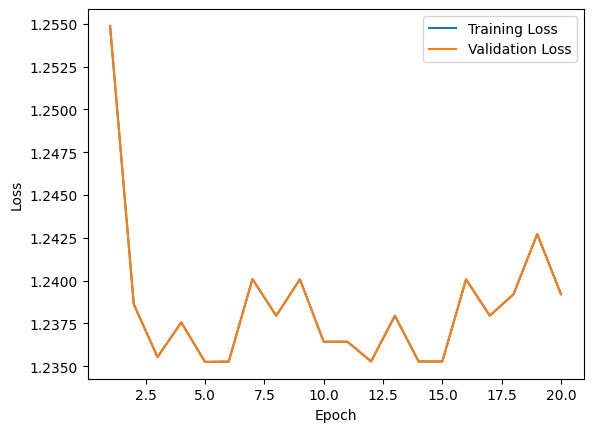

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_model = True

# Training hyperparameters
learning_rate = 0.01

# Model hyperparameters
print("Length english vocabulary:", len(vocab_en))
print("Length spanish vocabulary:",len(vocab_es))
input_size_encoder = len(vocab_en)
input_size_decoder = len(vocab_es)
output_size = len(vocab_es)
encoder_embedding_size = 256
decoder_embedding_size = 256
hidden_size = 512
num_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

step = 0

encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

train_losses = []
validation_losses = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    for batch in train_loader:
        #for _text,_label in batch:
        english_text, spanish_text = batch
        #print('target shape:',spanish_text.shape)
        optimizer.zero_grad()
        output = model(english_text, spanish_text,len(vocab_es))
        flat_target = spanish_text.view(-1)
        loss = criterion(output.view(-1, len(vocab_es)), flat_target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) #gradient clipping
        optimizer.step()
        scheduler.step()

    # Validation
    model.eval()
    total_validation_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            english_text, spanish_text = batch
            output = model(english_text, spanish_text, len(vocab_es))
            flat_target = spanish_text.view(-1)
            loss = criterion(output.view(-1, len(vocab_es)), flat_target)
            total_validation_loss += loss.item()
    
    average_validation_loss = total_validation_loss / len(valid_loader)
    print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Validation Loss: {average_validation_loss}')
    train_losses.append(loss.item())
    validation_losses.append(average_validation_loss)


print('ENTRENAMIENTO FINALIZADO')

# Plotting
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
# Create reverse vocabularies
reverse_vocab_en = {index: word for word, index in vocab_en.get_stoi().items()}
reverse_vocab_es = {index: word for word, index in vocab_es.get_stoi().items()}


# Testing (optional)
model.eval()
with torch.no_grad():
    for batch in test_loader:
        english_text, spanish_text = batch
        output = model(english_text, spanish_text,len(vocab_es))
        log_probs = F.log_softmax(output, dim=2)
        predicted_indices = log_probs.argmax(dim=2)
        
        print('ENGLISH INPUT TEXT: ',english_text.shape)
        sentence = untokenize_batch(english_text,reverse_vocab_en)
        print(''.join([' '.join(s) + '\n' for s in sentence]))

        print('SPANISH INPUT TEXT: ',spanish_text.shape)
        sentence = untokenize_batch(spanish_text,reverse_vocab_es)
        print(''.join([' '.join(s) + '\n' for s in sentence]))

        print('PREDICTED TEXT: ',predicted_indices.shape)
        sentence = untokenize_batch(predicted_indices,reverse_vocab_es)
        print(''.join([' '.join(s) + '\n' for s in sentence]))
        break

ENGLISH INPUT TEXT:  torch.Size([5, 300])
build a sandcastle on the beach
find shapes in fluffy clouds
dance like nobody is watching
smile at a passing butterfly
plant seeds and watch them grow

SPANISH INPUT TEXT:  torch.Size([5, 300])
construye un castillo de arena en la playa
encuentra formas en las nubes esponjosas
baila como si nadie estuviera mirando
sonríe a una mariposa que pasa
planta semillas y obsérvalas crecer

PREDICTED TEXT:  torch.Size([5, 300])

distancia para distancia las
y cielo para el
de familiar de cielo
y viento la la



In [5]:
#target shape: torch.Size([3, 300])
#predicted_indices shape: torch.Size([3, 300, 124])

batch_size = 3
sequence_size = 5
vocabulary_size = 4

spanish_text = torch.randint(0, vocabulary_size, (batch_size, sequence_size))
#print('target shape:',spanish_text.shape)
#print(spanish_text)
output = torch.randn((batch_size, sequence_size, vocabulary_size))  # Random values for demonstration
#print('\n output shape:', output.shape)
#print(output)

log_probs = F.log_softmax(output, dim=2)
predicted_indices = log_probs.argmax(dim=2)
#print('\nLog Probabilities (after log softmax):\n', log_probs)
#print('\nPredicted Indices (argmax):\n', predicted_indices)

flat_predicted_indices = predicted_indices.view(-1)
print(flat_predicted_indices)
flat_target = spanish_text.view(-1)
print(flat_target)

loss = criterion(output.view(-1, vocabulary_size), flat_target)

tensor([3, 0, 1, 3, 2, 0, 3, 1, 0, 3, 2, 0, 1, 2, 2])
tensor([2, 1, 1, 0, 3, 1, 0, 3, 2, 2, 3, 1, 2, 1, 3])
